# 9. Policy Graident Algo

## 9.1. Intro

## 9.2. Policy Gradient

策略学习目标：
$$
J(\theta) = \mathbb{E}_{s_0}[V^{\pi_\theta}(s_0)]
$$

$$
\begin{aligned}
\nabla_\theta J(\theta) &\propto \sum_{s \in S} v^{\pi_\theta}(s) \sum_{a \in A} Q^{\pi_\theta}(s, a) \nabla_\theta\pi_\theta(a | s) \\ 
 &= \sum_{s \in S} v^{\pi_\theta}(s) \sum_{a \in A} \pi_\theta(a | s) Q^{\pi_\theta}(s, a) \frac{\nabla_\theta\pi_\theta(a | s)}{\pi_\theta (a | s)} \\ 
 &= \mathbb{E}_{\pi_\theta}[Q^{\pi_\theta}(s, a) \nabla_\theta\log\pi_\theta(a | s)]
\end{aligned} 
$$
在线策略

REINFORCE，蒙特卡洛采样$Q^{\pi_\theta}(s, a)$
$$
\nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta}\left[\sum_{t=0}^T(\sum_{t' = t}^T\gamma^{t'-t}r_{t'})\nabla_\theta\log\pi_\theta(a_t | s_t)\right]
$$

## 9.3. REINFORCE

伪代码 REINFORCE：
1. 随机初始化策略参数$\theta$
2. **for**  $e = 1 \rightarrow E$ **do**:
   1. 用当前策略$\pi_\theta$采样轨迹 $\left\{s_1, a_1, r_1, s_2, a_2, r_2, ..., ..., s_T, a_T, r_T\right\}$
   2. 计算当前轨迹每个时刻$t$往后的回报$\psi_t = \sum_{t'=t}^T\gamma^{t' - t}r_{t'}$
   3. 对$\theta$更新：$\theta \leftarrow \theta + \alpha\sum_{t}^T\psi_t\nabla_\theta\log\pi_\theta(a_t|s_t)$
3. **end for**

In [22]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
if not hasattr(np, "bool8"):
  np.bool8 = np.bool_ # 这样写np不用降级
from tqdm import tqdm
import rl_utils

In [23]:
class PolicyNet(torch.nn.Module):
  """一层隐藏层的Q网络"""
  def __init__(self, state_dim, hidden_dim, action_dim):
    super(PolicyNet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
    
  def forward(self, x):
    x = F.relu(self.fc1(x)) 
    return F.softmax(self.fc2(x), dim=1)

In [24]:
class REINFORCE:
  def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
              device):
    self.policy_net = PolicyNet(state_dim, hidden_dim,
                      action_dim).to(device)
    self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate)
    self.gamma = gamma
    self.device = device
    
  def take_action(self, state): # 根据动作概率分布随机采样
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    probs = self.policy_net(state)
    action_dist = torch.distributions.Categorical(probs)
    action = action_dist.sample()
    return action.item()
  
  def update(self, transition_dict):
    reward_list = transition_dict['rewards']
    state_list = transition_dict['states']
    action_list = transition_dict['actions']
    
    G = 0
    self.optimizer.zero_grad()
    for i in reversed(range(len(reward_list))): 
      reward = reward_list[i]
      state = torch.tensor([state_list[i]], 
                          dtype=torch.float).to(self.device)
      action = torch.tensor([action_list[i]]).view(-1, 1).to(self.device)
      log_prob = torch.log(self.policy_net(state).gather(1, action))
      G = self.gamma * G + reward
      loss = -log_prob * G # 每一步的损失
      loss.backward()
    self.optimizer.step()

In [25]:
learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name ='CartPole-v1'
env = gym.make(env_name)
torch.manual_seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma, device)

return_list = []
for i in range(10):
  with tqdm(total=int(num_episodes / 10),desc='Iteration %d' % i) as pbar:
    for i_episode in range(int(num_episodes / 10)):
      episode_return = 0
      transition_dict = {
        'states': [],
        'actions': [],
        'next_states': [],
        'rewards': [],
        'dones': []
      }
      state, _ = env.reset(seed=0)
      done = False
      while not done:
        action = agent.take_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        transition_dict['states'].append(state)
        transition_dict['actions'].append(action)
        transition_dict['next_states'].append(next_state)
        transition_dict['rewards'].append(reward)
        transition_dict['dones'].append(done)
        state = next_state
        episode_return += reward
      return_list.append(episode_return)
      agent.update(transition_dict)
      if (i_episode + 1) % 10 == 0:
        pbar.set_postfix({
          'episode':
          '%d' % (num_episodes / 10 * i + i_episode + 1),
          'return':
          '%.3f' %np.mean(return_list[-10:])
        })
      pbar.update(1)



Iteration 9: 100%|██████████| 100/100 [00:16<00:00,  6.14it/s, episode=1000, return=158.500]


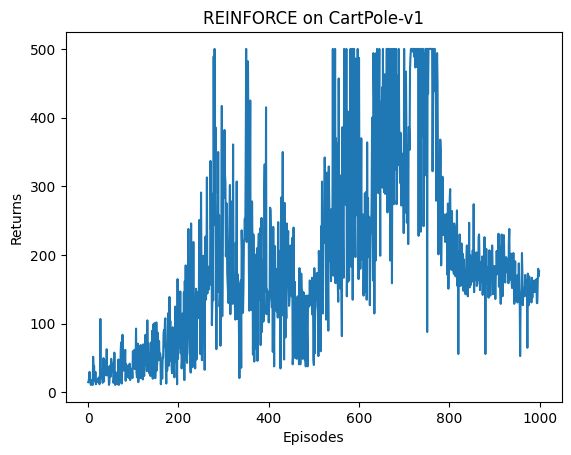

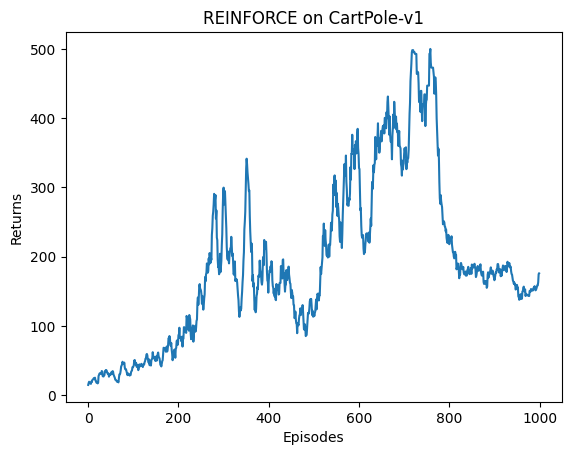

In [27]:
import matplotlib.pyplot as plt
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()